In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

## START

In [ ]:
train_gen=ImageDataGenerator(rescale=1/255.0,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
train_data=train_gen.flow_from_directory('/content/drive/MyDrive/Alzheimer Datasets/A4 Classes/Alzheimer_s Dataset/train', 
                                        target_size= (128, 128),
                                       class_mode = 'categorical', 
                                       batch_size = 32, 
                                       shuffle = True,
                                       subset='training')
test_data=train_gen.flow_from_directory('/content/drive/MyDrive/Alzheimer Datasets/A4 Classes/Alzheimer_s Dataset/test', 
                                        target_size= (128, 128),
                                        class_mode = 'categorical', 
                                        batch_size = 32, 
                                        shuffle = True)


Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


## Or

In [3]:
from sklearn.utils import shuffle
DATA=[]
for main_ in ['train', 'test']:
  for i,folder in enumerate(os.listdir(f'/content/drive/MyDrive/Alzheimer Datasets/A5 Classes/Alzheimers-ADNI/{main_}')):
    for image in os.listdir(f'/content/drive/MyDrive/Alzheimer Datasets/A5 Classes/Alzheimers-ADNI/{main_}/{folder}'):
      img=cv2.imread(f'/content/drive/MyDrive/Alzheimer Datasets/A5 Classes/Alzheimers-ADNI/{main_}/{folder}/{image}')
      img=cv2.resize(img,(128,128))/255.0
      DATA.append((img,i))
DATA=np.array(shuffle(DATA))

<ipython-input-3-35e9c4873570>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  DATA=np.array(shuffle(DATA))


In [4]:
DATA.shape

(1296, 2)

In [5]:
Images=np.array([i for i in DATA[:,0]]).reshape((1296,128,128,3))
Labels=DATA[:,1].astype(np.float32)

In [6]:
x_train,x_test,y_train,y_test=Images[:900],Images[900:],Labels[:900],Labels[900:]
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((900, 128, 128, 3), (396, 128, 128, 3), (900,), (396,))

In [7]:
from keras.utils import to_categorical
y_train=to_categorical(y_train,5)
y_test=to_categorical(y_test,5)
y_train.shape

(900, 5)

## Compact Convolutional Vision Transformer

## Loading Data

In [13]:
positional_emb = True
conv_layers = 4
projection_dim = 128
input_shape=(128,128,3)
image_size = 128
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
num_classes=4
num_heads = 4
transformer_units = [projection_dim,projection_dim]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 30
from sklearn.utils import shuffle
from keras import layers


In [14]:
class CCTTokenizer(layers.Layer):
    def __init__(self,kernel_size=3,stride=1,padding=1,pooling_kernel_size=3,pooling_stride=2,num_conv_layers=conv_layers,
        num_output_channels=[16, 128, 32, 128],positional_emb=positional_emb,**kwargs,):
      super(CCTTokenizer, self).__init__(**kwargs)
      self.conv_model = keras.Sequential()
      for i in range(num_conv_layers):
          self.conv_model.add(layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                ))
          self.conv_model.add(layers.ZeroPadding2D(padding))
          self.conv_model.add(layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same"))
      self.positional_emb = positional_emb
    def call(self, images):
        outputs = self.conv_model(images)
        reshaped = tf.reshape(
            outputs,  (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]))
        return reshaped
    def positional_embedding(self, image_size):
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

In [15]:
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop
    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (tf.shape(x).shape[0] - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

data_augmentation = keras.Sequential(
    [layers.RandomCrop(image_size, image_size),layers.RandomFlip("horizontal")],
    name="data_augmentation"
                    )

In [16]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) 
        return encoded

Image size: 128 X 128
Patch size: 8 X 8
Patches per image: 256
Elements per patch: 192


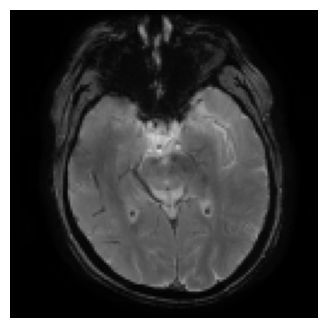

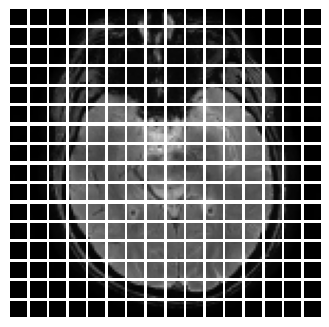

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

In [18]:
def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):

    inputs = layers.Input(input_shape)

    # Augment data.
    # augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    cct_encoded_patches = cct_tokenizer(inputs)

    patches = Patches(patch_size)(inputs)
    # Encode patches.
    default_encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        cct_encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1_c = layers.LayerNormalization(epsilon=1e-5)(cct_encoded_patches)
        x1_d = layers.LayerNormalization(epsilon=1e-5)(default_encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1_c, x1_d)
        attention_output_ = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1_d, x1_c)
        # Global Attension Fusion
        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2_c = layers.concatenate([attention_output, cct_encoded_patches])
        x2_d = layers.concatenate([attention_output_, default_encoded_patches])
        # print(x2_G)
        # Layer normalization 2.
        x3_c = layers.LayerNormalization(epsilon=1e-5)(x2_c)
        x3_d = layers.LayerNormalization(epsilon=1e-5)(x2_d)
        # MLP.
        x3_c = mlp(x3_c, hidden_units=transformer_units, dropout_rate=0.1)
        x3_d = mlp(x3_d, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        x3_c = StochasticDepth(dpr[i])(x3_c)
        cct_encoded_patches = layers.concatenate([x3_c, x2_c])
        x3_d = StochasticDepth(dpr[i])(x3_d)
        default_encoded_patches = layers.concatenate([x3_d, x2_d])
        # print(default_encoded_patches)

    # Apply sequence pooling.
    representation_1 = layers.LayerNormalization(epsilon=1e-5)(cct_encoded_patches)
    attention_weights_1 = tf.nn.softmax(layers.Dense(1)(representation_1), axis=1)
    weighted_representation_1 = tf.matmul(
        attention_weights_1, representation_1, transpose_a=True
    )
    weighted_representation_1 = tf.squeeze(weighted_representation_1, -2)
    # Apply sequence pooling.
    representation_2 = layers.LayerNormalization(epsilon=1e-5)(default_encoded_patches)
    attention_weights_2 = tf.nn.softmax(layers.Dense(1)(representation_2), axis=1)
    weighted_representation_2 = tf.matmul(
        attention_weights_2, representation_2, transpose_a=True
    )
    weighted_representation_2 = tf.squeeze(weighted_representation_2, -2)

    add_=keras.layers.concatenate([weighted_representation_1,weighted_representation_2])
    logits___ = layers.Dense(5,activation='sigmoid')(add_)

    model = keras.Model(inputs=inputs, outputs=logits___)
    return model

In [19]:
cct_model = create_cct_model()
cct_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 cct_tokenizer (CCTTokenizer)   (None, 64, 128)      92592       ['input_2[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 192)    0           ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 64, 128)     0           ['cct_tokenizer[0][0]']    

In [20]:
!pip install -U -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 21.1 MB/s eta 0:00:00


In [21]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def run_experiment(model):
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,loss='categorical_crossentropy',
     metrics=[keras.metrics.CategoricalAccuracy(),keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),keras.metrics.Recall(),
              keras.metrics.Precision(),get_f1, keras.metrics.AUC()],
                )
    model.summary()
    history = model.fit(x_train,y_train,batch_size=32,epochs=200,validation_data=[x_test,y_test])
    model.evaluate(x_test,y_test)
    return history

history = run_experiment(cct_model)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 cct_tokenizer (CCTTokenizer)   (None, 64, 128)      92592       ['input_2[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 192)    0           ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 64, 128)     0           ['cct_tokenizer[0][0]']    

In [22]:
cct_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 cct_tokenizer (CCTTokenizer)   (None, 64, 128)      92592       ['input_2[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 192)    0           ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 64, 128)     0           ['cct_tokenizer[0][0]']    

In [23]:
cct_model.evaluate(x_test,y_test)

13/13 [==============================] - 0s 35ms/step - loss: 4.4082 - categorical_accuracy: 0.4066 - top-5-accuracy: 1.0000 - recall_1: 0.6212 - precision_1: 0.3237 - get_f1: 0.4330 - auc_1: 0.6896


[4.408180236816406,
 0.40656566619873047,
 1.0,
 0.6212121248245239,
 0.3236842155456543,
 0.4329545199871063,
 0.689598023891449]

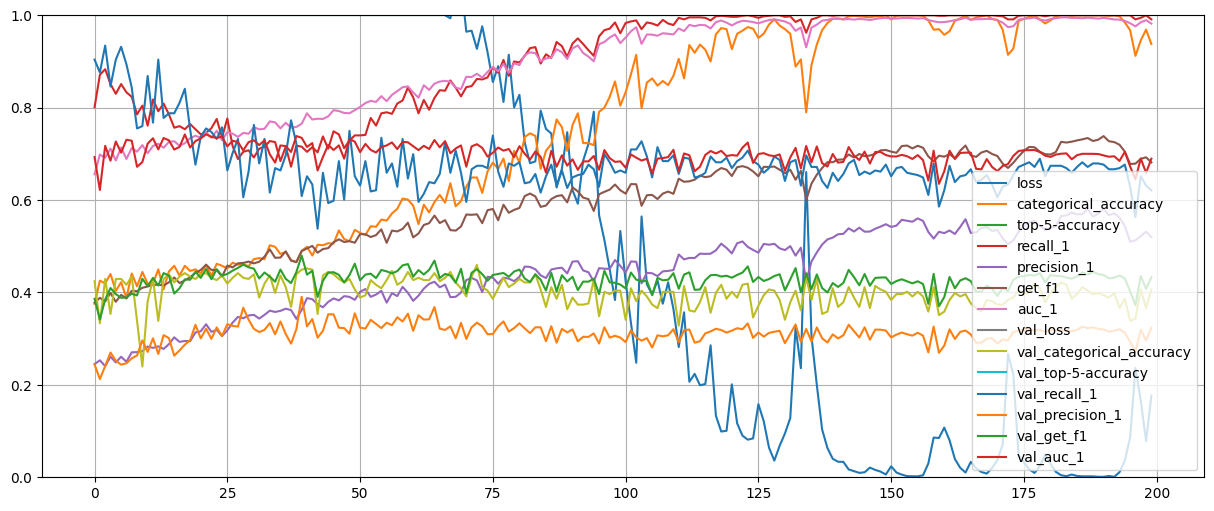

In [24]:
import pandas as pd
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_Bivit_without_Aug.png")
plt.show()

In [25]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'top-5-accuracy', 'recall_1', 'precision_1', 'get_f1', 'auc_1', 'val_loss', 'val_categorical_accuracy', 'val_top-5-accuracy', 'val_recall_1', 'val_precision_1', 'val_get_f1', 'val_auc_1'])

In [27]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_1']))
print(np.std(history.history['val_precision_1']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_1']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_1']))
print(np.mean(history.history['val_precision_1']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_1']))

0.030500315136979667
0.06437979364456432
0.022918651526141594
0.01936354165677959
0.021066265042067208
0.40108585797250274
0.6823863634467124
0.3113249991834164
0.4278489027917385
0.6997433930635453


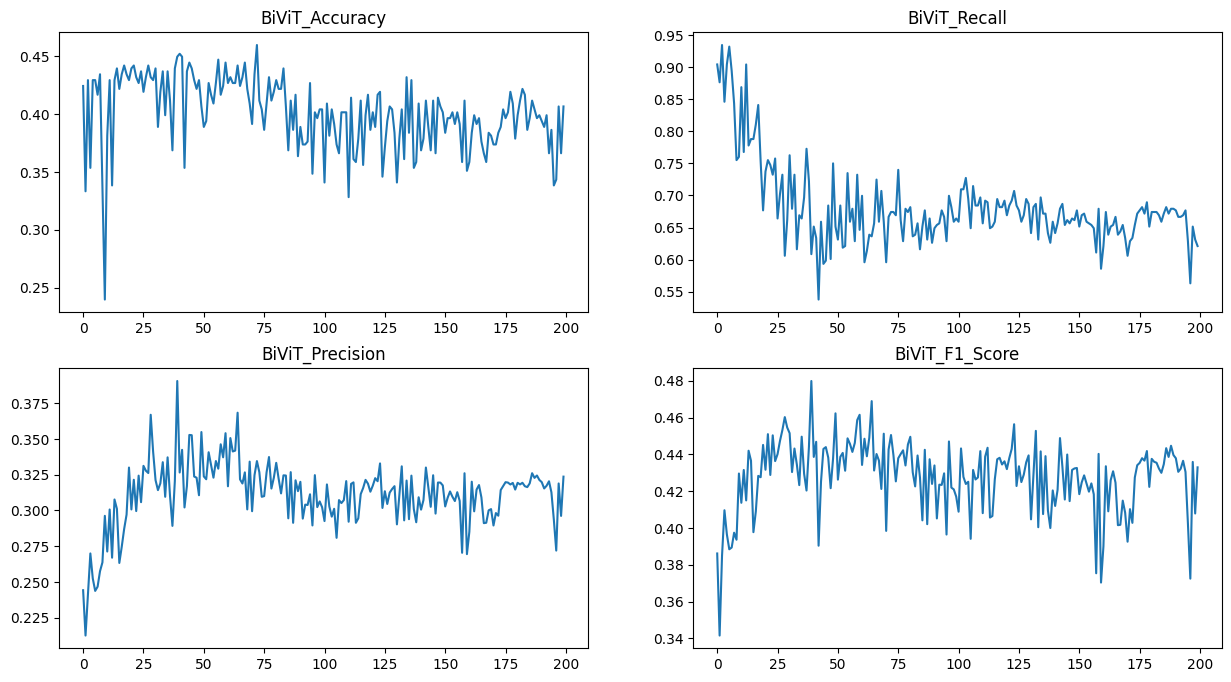

In [30]:
import pandas as pd
plt.rcParams['figure.figsize']=(15,8)
plt.subplot(2,2,1)
plt.plot(history.history['val_categorical_accuracy'])
plt.title('BiViT_Accuracy')
plt.subplot(2,2,2)
plt.plot(history.history['val_recall_1'])
plt.title('BiViT_Recall')
plt.subplot(2,2,3)
plt.plot(history.history['val_precision_1'])
plt.title('BiViT_Precision')
plt.subplot(2,2,4)
plt.plot(history.history['val_get_f1'])
plt.title('BiViT_F1_Score')
plt.savefig("cog_BiVit_without_Aug_seperate.png")
plt.show()

In [31]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(cct_model.predict(x_test),axis=1)))

13/13 [==============================] - 1s 38ms/step
              precision    recall  f1-score   support

           0       0.33      0.19      0.24        52
           1       0.46      0.66      0.54       170
           2       0.36      0.19      0.25        80
           3       0.19      0.20      0.20        20
           4       0.34      0.27      0.30        74

    accuracy                           0.41       396
   macro avg       0.34      0.30      0.31       396
weighted avg       0.39      0.41      0.38       396



In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.argmax(y_test,axis=1),np.argmax(cct_model.predict(x_test),axis=1))

13/13 [==============================] - 0s 31ms/step


array([[ 10,  29,   8,   0,   5],
       [ 12, 112,  13,  11,  22],
       [  6,  48,  15,   3,   8],
       [  0,  11,   1,   4,   4],
       [  2,  44,   5,   3,  20]])

13/13 [==============================] - 0s 31ms/step


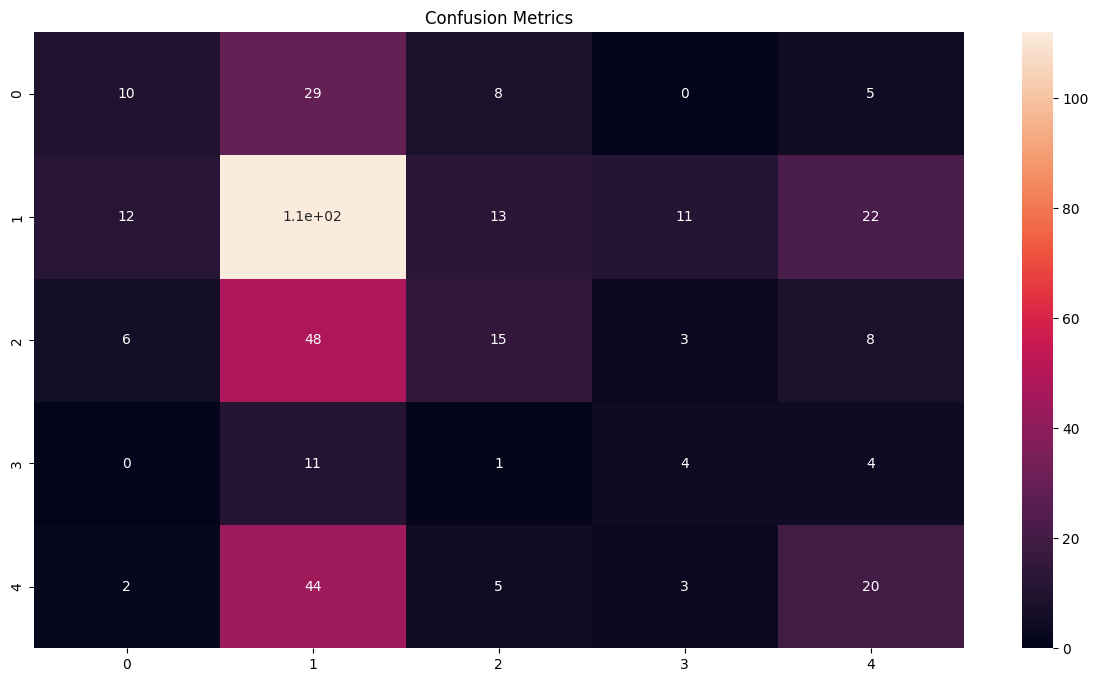

In [33]:
import seaborn as sns
sns.heatmap(confusion_matrix(np.argmax(y_test,axis=1),np.argmax(cct_model.predict(x_test),axis=1)),annot=True)
plt.title('Confusion Metrics')
plt.savefig("cog_BiVit_without_Aug_confusion.png")
plt.show()

## Transfer Learning

## DenseNet 121

In [8]:
import tensorflow as tf
model = tf.keras.applications.densenet.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(),get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

29084464/29084464 [==============================] - 1s 0us/step


Epoch 1/50
29/29 [==============================] - 23s 208ms/step - loss: 4.4253 - categorical_accuracy: 0.3200 - recall: 0.8333 - precision: 0.2134 - get_f1: 0.3437 - auc: 0.5914 - val_loss: 2.5109 - val_categorical_accuracy: 0.1944 - val_recall: 0.9874 - val_precision: 0.2066 - val_get_f1: 0.3405 - val_auc: 0.5218
Epoch 2/50
29/29 [==============================] - 1s 49ms/step - loss: 1.7783 - categorical_accuracy: 0.4478 - recall: 0.9800 - precision: 0.2225 - get_f1: 0.3628 - auc: 0.7281 - val_loss: 1.8434 - val_categorical_accuracy: 0.3510 - val_recall: 0.9949 - val_precision: 0.2161 - val_get_f1: 0.3556 - val_auc: 0.6546
Epoch 3/50
29/29 [==============================] - 2s 57ms/step - loss: 1.1608 - categorical_accuracy: 0.5744 - recall: 0.9967 - precision: 0.2173 - get_f1: 0.3571 - auc: 0.7943 - val_loss: 2.2986 - val_categorical_accuracy: 0.2525 - val_recall: 0.9949 - val_precision: 0.2107 - val_get_f1: 0.3481 - val_auc: 0.6290
Epoch 4/50
29/29 [=============================

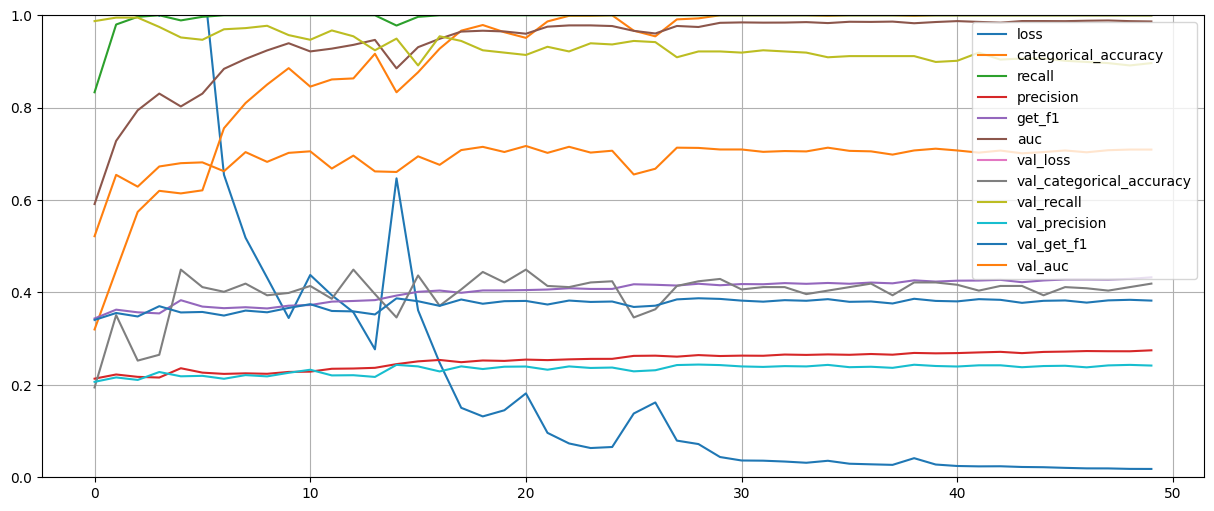

In [9]:
import pandas as pd
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("Cog_Densenet121_without_Aug.png")
plt.show()

In [10]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 3s 37ms/step
              precision    recall  f1-score   support

           0       0.33      0.23      0.27        52
           1       0.48      0.66      0.56       170
           2       0.38      0.25      0.30        80
           3       0.17      0.10      0.12        20
           4       0.32      0.27      0.29        74

    accuracy                           0.42       396
   macro avg       0.34      0.30      0.31       396
weighted avg       0.39      0.42      0.40       396



In [11]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall']))
print(np.std(history.history['val_precision']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc']))

0.04709067383368654
0.027785170323702403
0.010159173372293141
0.01195581947270751
0.03133450371176748


In [12]:
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall']))
print(np.mean(history.history['val_precision']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc']))

0.3981313169002533
0.9309595954418183
0.23369467228651047
0.3745112597942352
0.6922686386108399


In [ ]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Resnet 50

In [34]:
import tensorflow as tf
model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(),get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

94765736/94765736 [==============================] - 3s 0us/step


Epoch 1/50
29/29 [==============================] - 8s 141ms/step - loss: 1.5223 - categorical_accuracy: 0.4411 - recall_2: 0.8889 - precision_2: 0.2401 - get_f1: 0.3747 - auc_2: 0.6834 - val_loss: 1.4527 - val_categorical_accuracy: 0.4369 - val_recall_2: 0.9874 - val_precision_2: 0.2050 - val_get_f1: 0.3397 - val_auc_2: 0.7001
Epoch 2/50
29/29 [==============================] - 2s 58ms/step - loss: 1.4363 - categorical_accuracy: 0.4689 - recall_2: 0.9178 - precision_2: 0.2326 - get_f1: 0.3737 - auc_2: 0.7093 - val_loss: 1.4546 - val_categorical_accuracy: 0.4343 - val_recall_2: 0.8460 - val_precision_2: 0.2405 - val_get_f1: 0.3744 - val_auc_2: 0.7022
Epoch 3/50
29/29 [==============================] - 2s 60ms/step - loss: 1.4119 - categorical_accuracy: 0.4700 - recall_2: 0.9156 - precision_2: 0.2411 - get_f1: 0.3810 - auc_2: 0.7195 - val_loss: 1.4684 - val_categorical_accuracy: 0.4419 - val_recall_2: 0.9419 - val_precision_2: 0.2380 - val_get_f1: 0.3810 - val_auc_2: 0.7051
Epoch 4/50
2

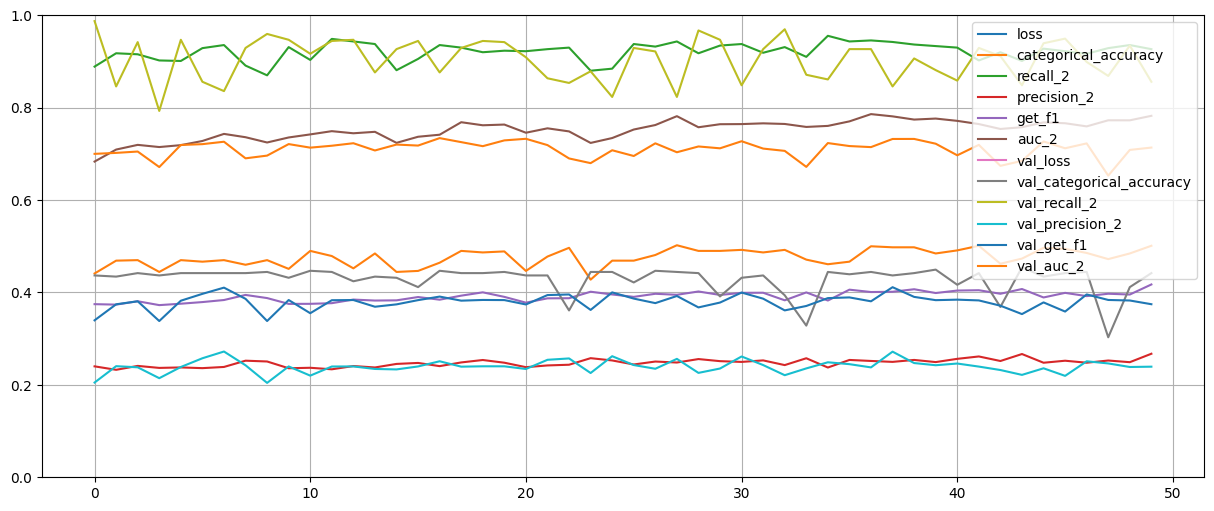

In [35]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_Resnet50_without_Aug.png")
plt.show()

In [36]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 1s 36ms/step
              precision    recall  f1-score   support

           0       1.00      0.12      0.21        52
           1       0.44      0.98      0.61       170
           2       0.00      0.00      0.00        80
           3       0.00      0.00      0.00        20
           4       0.22      0.03      0.05        74

    accuracy                           0.44       396
   macro avg       0.33      0.22      0.17       396
weighted avg       0.36      0.44      0.30       396



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_2']))
print(np.std(history.history['val_precision_2']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_2']))

0.029836474224084513
0.04551353637685053
0.014084031533346218
0.015906989582038417
0.017838096685112544


In [38]:
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_2']))
print(np.mean(history.history['val_precision_2']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_2']))

0.42878787755966186
0.9033333325386047
0.2397083482146263
0.3795366710424423
0.7101704859733582


## Vgg16

In [39]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

58889256/58889256 [==============================] - 2s 0us/step


Epoch 1/50
29/29 [==============================] - 7s 147ms/step - loss: 1.5257 - categorical_accuracy: 0.4044 - recall_3: 0.9322 - precision_3: 0.2236 - get_f1: 0.3609 - auc_3: 0.6817 - val_loss: 1.5030 - val_categorical_accuracy: 0.4520 - val_recall_3: 0.9293 - val_precision_3: 0.2439 - val_get_f1: 0.3877 - val_auc_3: 0.7188
Epoch 2/50
29/29 [==============================] - 2s 66ms/step - loss: 1.3487 - categorical_accuracy: 0.4767 - recall_3: 0.9478 - precision_3: 0.2319 - get_f1: 0.3745 - auc_3: 0.7534 - val_loss: 1.4113 - val_categorical_accuracy: 0.4268 - val_recall_3: 0.9571 - val_precision_3: 0.2382 - val_get_f1: 0.3821 - val_auc_3: 0.7144
Epoch 3/50
29/29 [==============================] - 2s 74ms/step - loss: 1.2709 - categorical_accuracy: 0.4833 - recall_3: 0.9833 - precision_3: 0.2301 - get_f1: 0.3755 - auc_3: 0.7798 - val_loss: 1.4130 - val_categorical_accuracy: 0.4621 - val_recall_3: 0.9672 - val_precision_3: 0.2302 - val_get_f1: 0.3741 - val_auc_3: 0.7345
Epoch 4/50
2

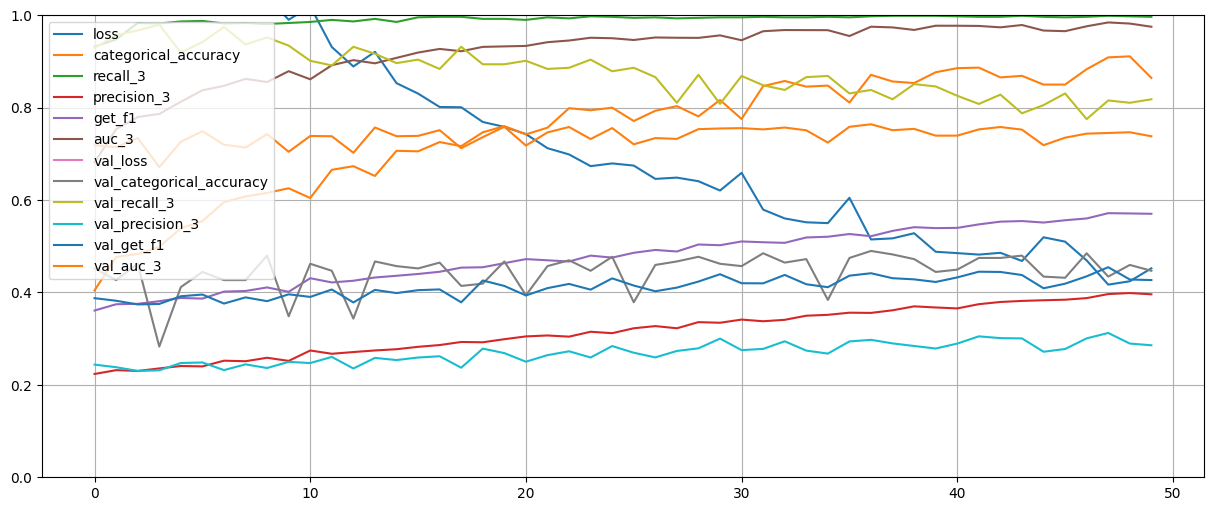

In [40]:
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_Vgg16_without_Aug.png")
plt.show()

In [41]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 1s 43ms/step
              precision    recall  f1-score   support

           0       0.37      0.25      0.30        52
           1       0.59      0.58      0.58       170
           2       0.32      0.51      0.39        80
           3       0.29      0.30      0.29        20
           4       0.43      0.26      0.32        74

    accuracy                           0.45       396
   macro avg       0.40      0.38      0.38       396
weighted avg       0.46      0.45      0.44       396



In [42]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_3']))
print(np.std(history.history['val_precision_3']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_3']))

0.04018679113038822
0.051972345957771435
0.02206483606992053
0.021028614458270745
0.018389502100389893


In [43]:
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_3']))
print(np.mean(history.history['val_precision_3']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_3']))

0.44484848499298096
0.8763131308555603
0.2688577824831009
0.41216204345226287
0.7382634806632996


## Inception Resnet V2

In [44]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

219055592/219055592 [==============================] - 7s 0us/step


Epoch 1/50
29/29 [==============================] - 32s 340ms/step - loss: 2.9086 - categorical_accuracy: 0.3067 - recall_4: 0.9289 - precision_4: 0.2142 - get_f1: 0.3495 - auc_4: 0.5894 - val_loss: 2.1442 - val_categorical_accuracy: 0.2475 - val_recall_4: 0.9949 - val_precision_4: 0.2067 - val_get_f1: 0.3419 - val_auc_4: 0.6172
Epoch 2/50
29/29 [==============================] - 3s 109ms/step - loss: 1.5266 - categorical_accuracy: 0.4311 - recall_4: 1.0000 - precision_4: 0.2013 - get_f1: 0.3350 - auc_4: 0.6887 - val_loss: 1.7829 - val_categorical_accuracy: 0.3611 - val_recall_4: 0.9975 - val_precision_4: 0.2033 - val_get_f1: 0.3376 - val_auc_4: 0.6470
Epoch 3/50
29/29 [==============================] - 3s 89ms/step - loss: 1.2457 - categorical_accuracy: 0.5356 - recall_4: 1.0000 - precision_4: 0.2057 - get_f1: 0.3421 - auc_4: 0.7250 - val_loss: 1.8753 - val_categorical_accuracy: 0.3586 - val_recall_4: 0.9924 - val_precision_4: 0.2096 - val_get_f1: 0.3460 - val_auc_4: 0.6607
Epoch 4/50

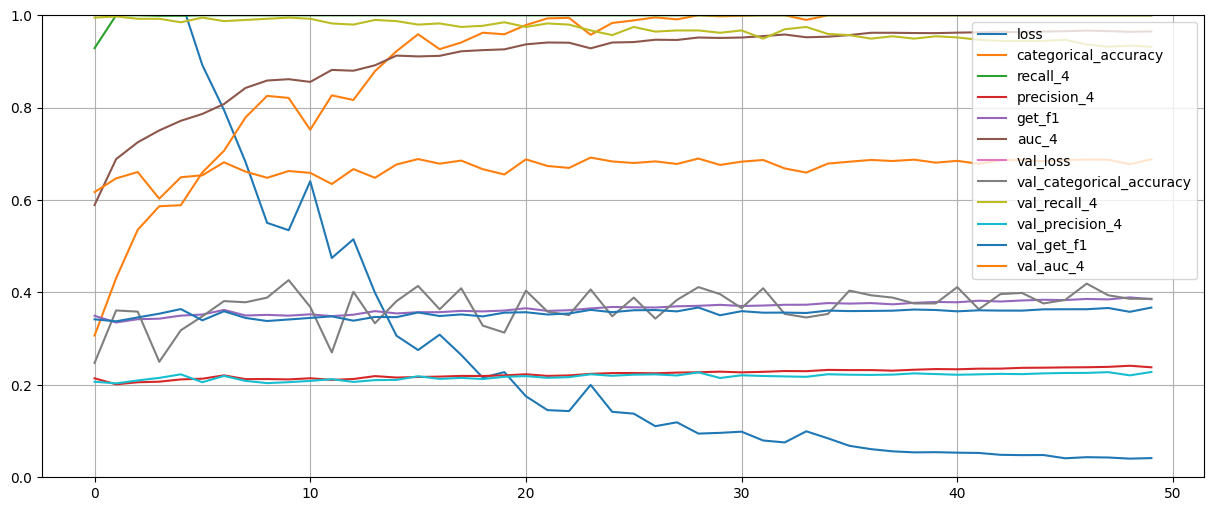

In [45]:
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_Inception_ResnerV2_without_Aug.png")
plt.show()

In [46]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 4s 64ms/step
              precision    recall  f1-score   support

           0       0.36      0.19      0.25        52
           1       0.48      0.65      0.55       170
           2       0.28      0.25      0.26        80
           3       0.12      0.05      0.07        20
           4       0.20      0.16      0.18        74

    accuracy                           0.39       396
   macro avg       0.29      0.26      0.26       396
weighted avg       0.35      0.39      0.36       396



In [47]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_4']))
print(np.std(history.history['val_precision_4']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_4']))

0.03911595960694831
0.019098926006251998
0.006719316429734846
0.008164799999373307
0.01883821769995836


In [48]:
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_4']))
print(np.mean(history.history['val_precision_4']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_4']))

0.37040404230356216
0.9689898991584778
0.21768939703702928
0.3551952886581421
0.6722183918952942


## Inception v3

In [49]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

87910968/87910968 [==============================] - 3s 0us/step


Epoch 1/50
29/29 [==============================] - 16s 340ms/step - loss: 3.2252 - categorical_accuracy: 0.3256 - recall_5: 0.9544 - precision_5: 0.2191 - get_f1: 0.3575 - auc_5: 0.5885 - val_loss: 2.9964 - val_categorical_accuracy: 0.3384 - val_recall_5: 1.0000 - val_precision_5: 0.2004 - val_get_f1: 0.3339 - val_auc_5: 0.6019
Epoch 2/50
29/29 [==============================] - 2s 58ms/step - loss: 2.2090 - categorical_accuracy: 0.4089 - recall_5: 1.0000 - precision_5: 0.2004 - get_f1: 0.3338 - auc_5: 0.5723 - val_loss: 1.9758 - val_categorical_accuracy: 0.3106 - val_recall_5: 0.9975 - val_precision_5: 0.2001 - val_get_f1: 0.3333 - val_auc_5: 0.5496
Epoch 3/50
29/29 [==============================] - 2s 58ms/step - loss: 1.3298 - categorical_accuracy: 0.5333 - recall_5: 1.0000 - precision_5: 0.2008 - get_f1: 0.3344 - auc_5: 0.5530 - val_loss: 2.4094 - val_categorical_accuracy: 0.2955 - val_recall_5: 1.0000 - val_precision_5: 0.2000 - val_get_f1: 0.3333 - val_auc_5: 0.5365
Epoch 4/50


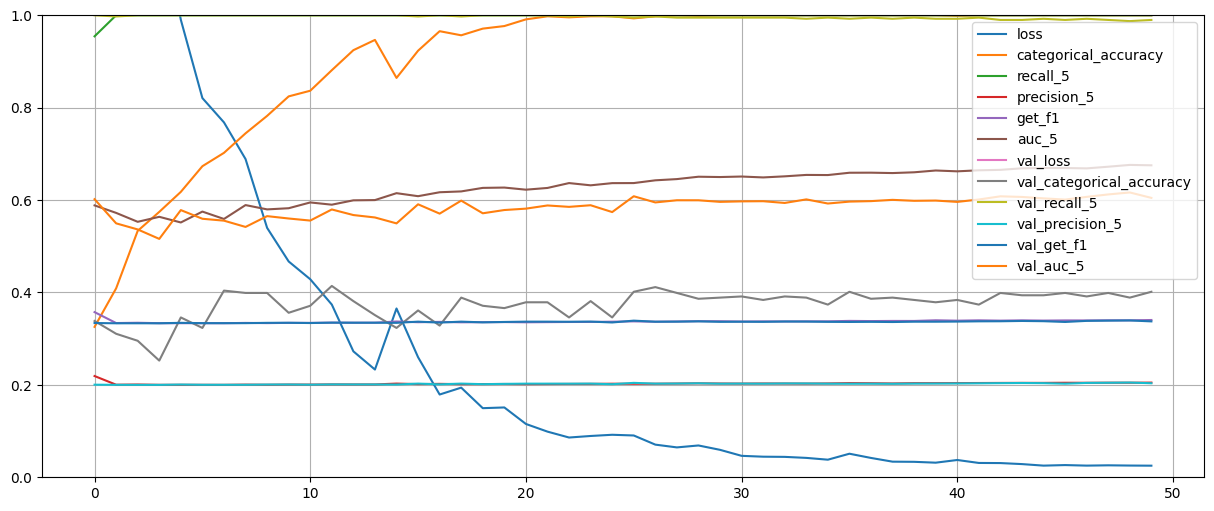

In [50]:
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_InceptionV3_without_Aug.png")
plt.show()

In [51]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 2s 33ms/step
              precision    recall  f1-score   support

           0       0.33      0.25      0.28        52
           1       0.49      0.64      0.56       170
           2       0.28      0.28      0.28        80
           3       0.00      0.00      0.00        20
           4       0.30      0.22      0.25        74

    accuracy                           0.40       396
   macro avg       0.28      0.28      0.27       396
weighted avg       0.37      0.40      0.38       396



In [52]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_5']))
print(np.std(history.history['val_precision_5']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_5']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_5']))
print(np.mean(history.history['val_precision_5']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_5']))

0.031761855881765194
0.0037195858228724625
0.0013427088115254711
0.0016432935216368692
0.022040537641662642
0.37383838295936583
0.996262629032135
0.20221682131290436
0.33607942938804625
0.5847660505771637


## Efficient B0

In [53]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

16705208/16705208 [==============================] - 1s 0us/step


Epoch 1/50
29/29 [==============================] - 13s 225ms/step - loss: 2.3427 - categorical_accuracy: 0.2922 - recall_6: 0.9200 - precision_6: 0.2202 - get_f1: 0.3610 - auc_6: 0.6387 - val_loss: 2.0158 - val_categorical_accuracy: 0.1869 - val_recall_6: 1.0000 - val_precision_6: 0.2000 - val_get_f1: 0.3333 - val_auc_6: 0.5385
Epoch 2/50
29/29 [==============================] - 1s 36ms/step - loss: 1.7302 - categorical_accuracy: 0.3378 - recall_6: 0.9789 - precision_6: 0.2141 - get_f1: 0.3527 - auc_6: 0.6625 - val_loss: 1.9854 - val_categorical_accuracy: 0.4293 - val_recall_6: 1.0000 - val_precision_6: 0.2000 - val_get_f1: 0.3333 - val_auc_6: 0.6861
Epoch 3/50
29/29 [==============================] - 1s 38ms/step - loss: 1.6903 - categorical_accuracy: 0.3378 - recall_6: 1.0000 - precision_6: 0.2008 - get_f1: 0.3344 - auc_6: 0.6597 - val_loss: 1.6512 - val_categorical_accuracy: 0.4293 - val_recall_6: 1.0000 - val_precision_6: 0.2000 - val_get_f1: 0.3333 - val_auc_6: 0.6449
Epoch 4/50


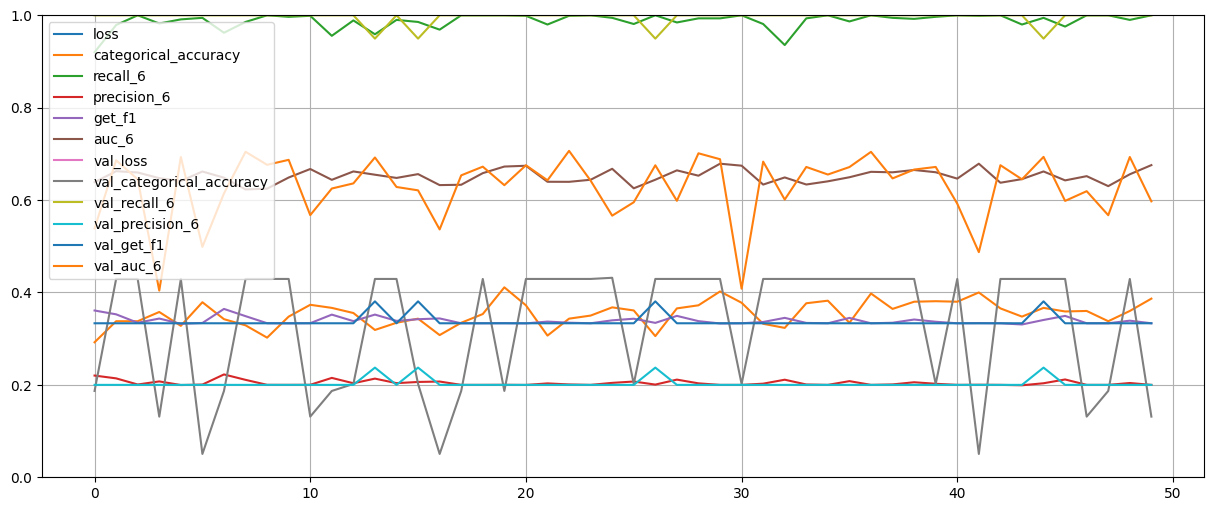

In [54]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_EfficientB0_without_Aug.png")
plt.show()

In [55]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 2s 27ms/step
              precision    recall  f1-score   support

           0       0.13      1.00      0.23        52
           1       0.00      0.00      0.00       170
           2       0.00      0.00      0.00        80
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        74

    accuracy                           0.13       396
   macro avg       0.03      0.20      0.05       396
weighted avg       0.02      0.13      0.03       396



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_6']))
print(np.std(history.history['val_precision_6']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_6']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_6']))
print(np.mean(history.history['val_precision_6']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_6']))

0.13513136218861416
0.013701674446872392
0.0101392405460157
0.012869047738934429
0.0697602393487811
0.3309595875442028
0.9959595966339111
0.20298990190029145
0.33712815880775454
0.6290559756755829


## EfficientNet B1

In [57]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

27018416/27018416 [==============================] - 2s 0us/step


Epoch 1/50
29/29 [==============================] - 17s 175ms/step - loss: 3.6621 - categorical_accuracy: 0.2778 - recall_7: 0.8344 - precision_7: 0.2132 - get_f1: 0.3389 - auc_7: 0.5949 - val_loss: 1.7789 - val_categorical_accuracy: 0.4293 - val_recall_7: 1.0000 - val_precision_7: 0.2000 - val_get_f1: 0.3333 - val_auc_7: 0.6651
Epoch 2/50
29/29 [==============================] - 2s 61ms/step - loss: 1.6760 - categorical_accuracy: 0.3556 - recall_7: 0.9878 - precision_7: 0.2073 - get_f1: 0.3451 - auc_7: 0.6200 - val_loss: 2.1765 - val_categorical_accuracy: 0.4293 - val_recall_7: 1.0000 - val_precision_7: 0.2000 - val_get_f1: 0.3333 - val_auc_7: 0.6350
Epoch 3/50
29/29 [==============================] - 2s 63ms/step - loss: 1.8498 - categorical_accuracy: 0.3411 - recall_7: 1.0000 - precision_7: 0.2000 - get_f1: 0.3333 - auc_7: 0.6057 - val_loss: 2.1899 - val_categorical_accuracy: 0.0505 - val_recall_7: 1.0000 - val_precision_7: 0.2000 - val_get_f1: 0.3333 - val_auc_7: 0.5328
Epoch 4/50


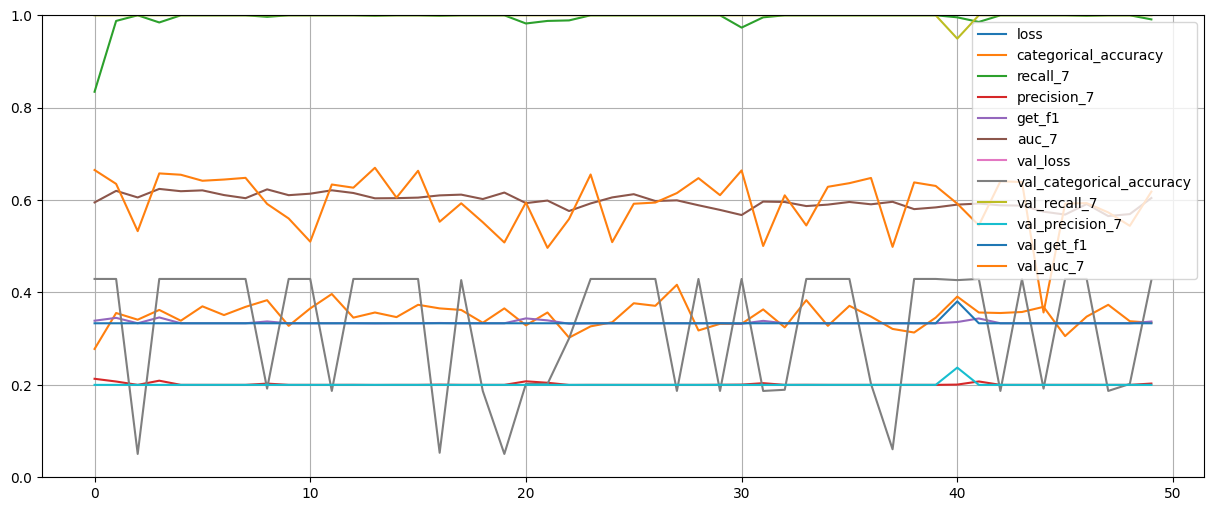

In [58]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_EfficientB1_without_Aug.png")
plt.show()

In [59]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 2s 35ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.43      0.99      0.60       170
           2       0.00      0.00      0.00        80
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        74

    accuracy                           0.43       396
   macro avg       0.09      0.20      0.12       396
weighted avg       0.18      0.43      0.26       396



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_7']))
print(np.std(history.history['val_precision_7']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_7']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_7']))
print(np.mean(history.history['val_precision_7']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_7']))

0.13246583779646337
0.007070705890655517
0.005232323110103607
0.006641031503677369
0.06077056712274386
0.33010100230574607
0.9989898991584778
0.20074747771024704
0.33428200244903566
0.5943699294328689


## VGG19

In [61]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.vgg19.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

80134624/80134624 [==============================] - 3s 0us/step


Epoch 1/50
29/29 [==============================] - 4s 97ms/step - loss: 1.5653 - categorical_accuracy: 0.3800 - recall_8: 0.5756 - precision_8: 0.3115 - get_f1: 0.4107 - auc_8: 0.6689 - val_loss: 1.5038 - val_categorical_accuracy: 0.4141 - val_recall_8: 0.8106 - val_precision_8: 0.2767 - val_get_f1: 0.4132 - val_auc_8: 0.7230
Epoch 2/50
29/29 [==============================] - 2s 76ms/step - loss: 1.3797 - categorical_accuracy: 0.4667 - recall_8: 0.6344 - precision_8: 0.3605 - get_f1: 0.4628 - auc_8: 0.7406 - val_loss: 1.4330 - val_categorical_accuracy: 0.4268 - val_recall_8: 0.4874 - val_precision_8: 0.3792 - val_get_f1: 0.4315 - val_auc_8: 0.7066
Epoch 3/50
29/29 [==============================] - 2s 75ms/step - loss: 1.2760 - categorical_accuracy: 0.5044 - recall_8: 0.6889 - precision_8: 0.3851 - get_f1: 0.5020 - auc_8: 0.7788 - val_loss: 1.4365 - val_categorical_accuracy: 0.4520 - val_recall_8: 0.5480 - val_precision_8: 0.3938 - val_get_f1: 0.4564 - val_auc_8: 0.7288
Epoch 4/50
29

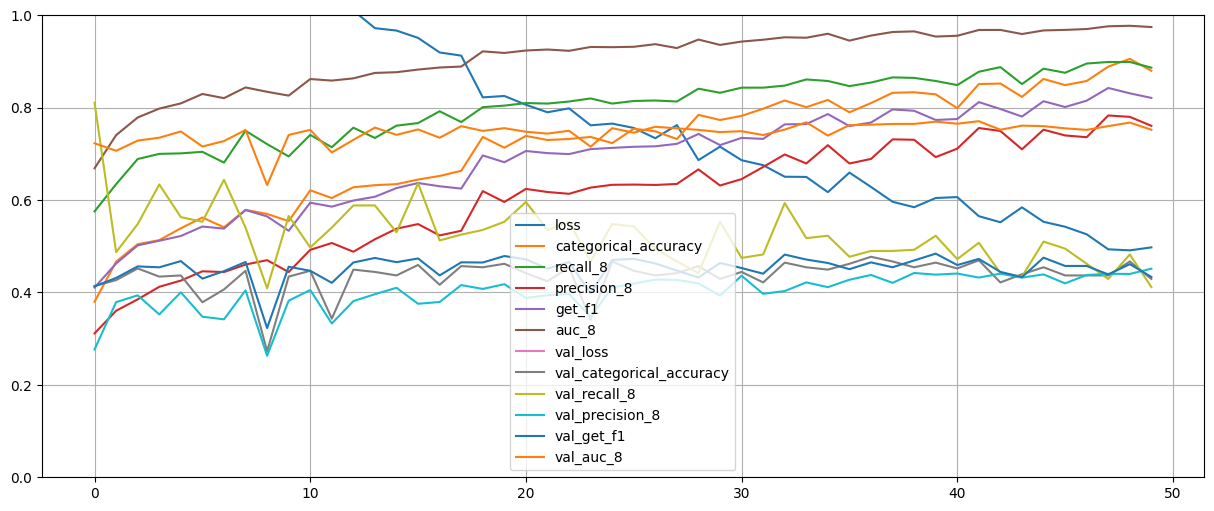

In [62]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_VGG19_without_Aug.png")
plt.show()

In [63]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 1s 51ms/step
              precision    recall  f1-score   support

           0       0.24      0.21      0.22        52
           1       0.52      0.72      0.61       170
           2       0.37      0.21      0.27        80
           3       0.27      0.35      0.30        20
           4       0.29      0.18      0.22        74

    accuracy                           0.43       396
   macro avg       0.34      0.33      0.32       396
weighted avg       0.40      0.43      0.40       396



In [64]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_8']))
print(np.std(history.history['val_precision_8']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_8']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_8']))
print(np.mean(history.history['val_precision_8']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_8']))

0.03560047292854937
0.06834257053288727
0.03938383528430296
0.025781201468292207
0.022578575837731263
0.43641414284706115
0.5234343403577805
0.40200553834438324
0.4528379637002945
0.7458259201049805


## Resnet101

In [65]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.resnet.ResNet101(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

171446536/171446536 [==============================] - 6s 0us/step


Epoch 1/50
29/29 [==============================] - 12s 172ms/step - loss: 1.5441 - categorical_accuracy: 0.3867 - recall_9: 0.6267 - precision_9: 0.2895 - get_f1: 0.4010 - auc_9: 0.6704 - val_loss: 1.4176 - val_categorical_accuracy: 0.4369 - val_recall_9: 0.8005 - val_precision_9: 0.2707 - val_get_f1: 0.4052 - val_auc_9: 0.7106
Epoch 2/50
29/29 [==============================] - 3s 107ms/step - loss: 1.4239 - categorical_accuracy: 0.4544 - recall_9: 0.7011 - precision_9: 0.2943 - get_f1: 0.4179 - auc_9: 0.7169 - val_loss: 1.4407 - val_categorical_accuracy: 0.4394 - val_recall_9: 0.5631 - val_precision_9: 0.3132 - val_get_f1: 0.4059 - val_auc_9: 0.6936
Epoch 3/50
29/29 [==============================] - 3s 92ms/step - loss: 1.3791 - categorical_accuracy: 0.4756 - recall_9: 0.6944 - precision_9: 0.3131 - get_f1: 0.4323 - auc_9: 0.7319 - val_loss: 1.4662 - val_categorical_accuracy: 0.4369 - val_recall_9: 0.6414 - val_precision_9: 0.3101 - val_get_f1: 0.4186 - val_auc_9: 0.7121
Epoch 4/50

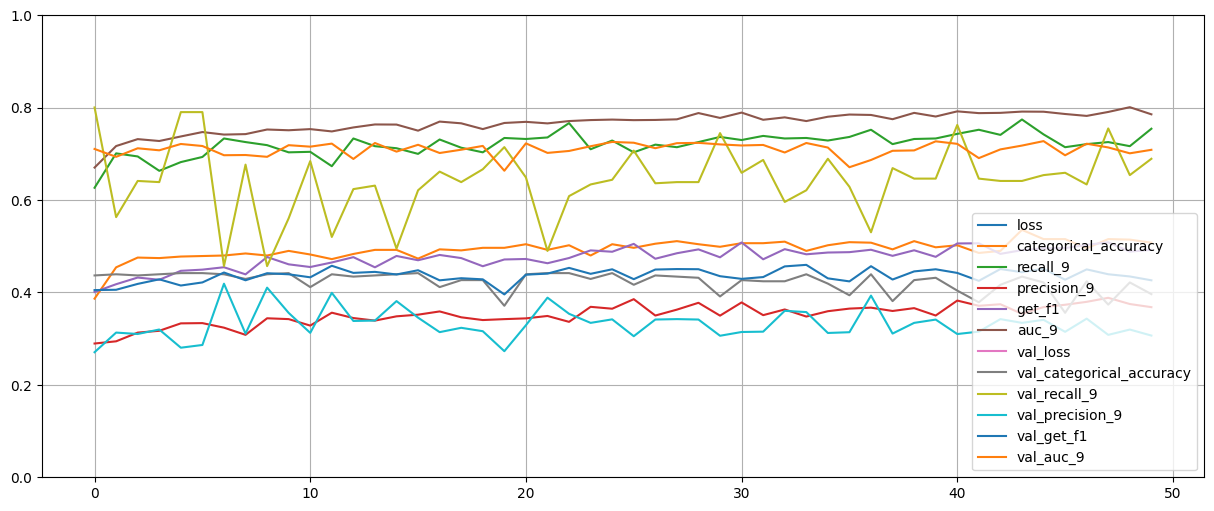

In [66]:
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_Resnet101_without_Aug.png")
plt.show()

In [67]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 2s 58ms/step
              precision    recall  f1-score   support

           0       0.35      0.13      0.19        52
           1       0.49      0.64      0.55       170
           2       0.29      0.45      0.35        80
           3       0.00      0.00      0.00        20
           4       0.19      0.07      0.10        74

    accuracy                           0.40       396
   macro avg       0.26      0.26      0.24       396
weighted avg       0.35      0.40      0.35       396



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_9']))
print(np.std(history.history['val_precision_9']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_9']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_9']))
print(np.mean(history.history['val_precision_9']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_9']))

0.02140818350878676
0.07576976235046647
0.03199085818634673
0.014018562071533177
0.013851800874900158
0.4233333319425583
0.642727273106575
0.33187480390071866
0.43671086728572844
0.7100310552120209


## MobileNet

In [69]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.mobilenet.MobileNet(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

17225924/17225924 [==============================] - 1s 0us/step


Epoch 1/50
29/29 [==============================] - 5s 88ms/step - loss: 3.5046 - categorical_accuracy: 0.3233 - recall_10: 0.8700 - precision_10: 0.2310 - get_f1: 0.3610 - auc_10: 0.6249 - val_loss: 2.5148 - val_categorical_accuracy: 0.3561 - val_recall_10: 0.9419 - val_precision_10: 0.2389 - val_get_f1: 0.3824 - val_auc_10: 0.6512
Epoch 2/50
29/29 [==============================] - 1s 24ms/step - loss: 1.5900 - categorical_accuracy: 0.5344 - recall_10: 0.9700 - precision_10: 0.2318 - get_f1: 0.3743 - auc_10: 0.7513 - val_loss: 2.0955 - val_categorical_accuracy: 0.4520 - val_recall_10: 0.9848 - val_precision_10: 0.2146 - val_get_f1: 0.3525 - val_auc_10: 0.7058
Epoch 3/50
29/29 [==============================] - 1s 22ms/step - loss: 0.6709 - categorical_accuracy: 0.7667 - recall_10: 0.9989 - precision_10: 0.2280 - get_f1: 0.3736 - auc_10: 0.8509 - val_loss: 1.7628 - val_categorical_accuracy: 0.4394 - val_recall_10: 0.9823 - val_precision_10: 0.2150 - val_get_f1: 0.3532 - val_auc_10: 0.

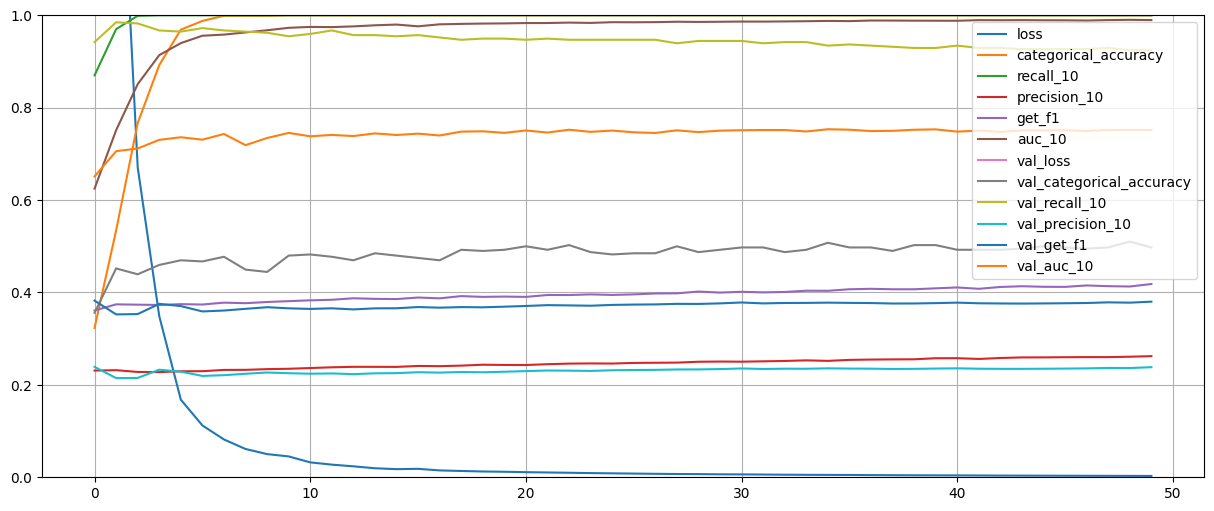

In [70]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_Mobilenet_without_Aug.png")
plt.show()

In [71]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 1s 13ms/step
              precision    recall  f1-score   support

           0       0.48      0.31      0.38        52
           1       0.51      0.76      0.61       170
           2       0.51      0.35      0.41        80
           3       0.75      0.15      0.25        20
           4       0.40      0.27      0.32        74

    accuracy                           0.50       396
   macro avg       0.53      0.37      0.40       396
weighted avg       0.50      0.50      0.47       396



In [72]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_10']))
print(np.std(history.history['val_precision_10']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_10']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_10']))
print(np.mean(history.history['val_precision_10']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_10']))

0.02409938145437116
0.01499957813274081
0.005708285343339968
0.006641272923523456
0.0164970231375321
0.48328283250331877
0.9462626230716705
0.23067408204078674
0.37196497201919554
0.7428150486946106


## Xception

In [73]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.xception.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

83683744/83683744 [==============================] - 3s 0us/step


Epoch 1/50
29/29 [==============================] - 10s 151ms/step - loss: 3.4481 - categorical_accuracy: 0.3156 - recall_11: 0.7978 - precision_11: 0.2284 - get_f1: 0.3678 - auc_11: 0.6089 - val_loss: 3.5365 - val_categorical_accuracy: 0.4293 - val_recall_11: 0.8535 - val_precision_11: 0.2534 - val_get_f1: 0.3954 - val_auc_11: 0.7014
Epoch 2/50
29/29 [==============================] - 2s 66ms/step - loss: 1.7823 - categorical_accuracy: 0.4800 - recall_11: 0.9644 - precision_11: 0.2204 - get_f1: 0.3612 - auc_11: 0.7415 - val_loss: 1.8829 - val_categorical_accuracy: 0.3283 - val_recall_11: 0.9621 - val_precision_11: 0.2353 - val_get_f1: 0.3789 - val_auc_11: 0.6521
Epoch 3/50
29/29 [==============================] - 2s 62ms/step - loss: 1.0448 - categorical_accuracy: 0.6067 - recall_11: 0.9956 - precision_11: 0.2221 - get_f1: 0.3637 - auc_11: 0.8330 - val_loss: 2.2248 - val_categorical_accuracy: 0.2854 - val_recall_11: 0.9722 - val_precision_11: 0.2024 - val_get_f1: 0.3351 - val_auc_11: 

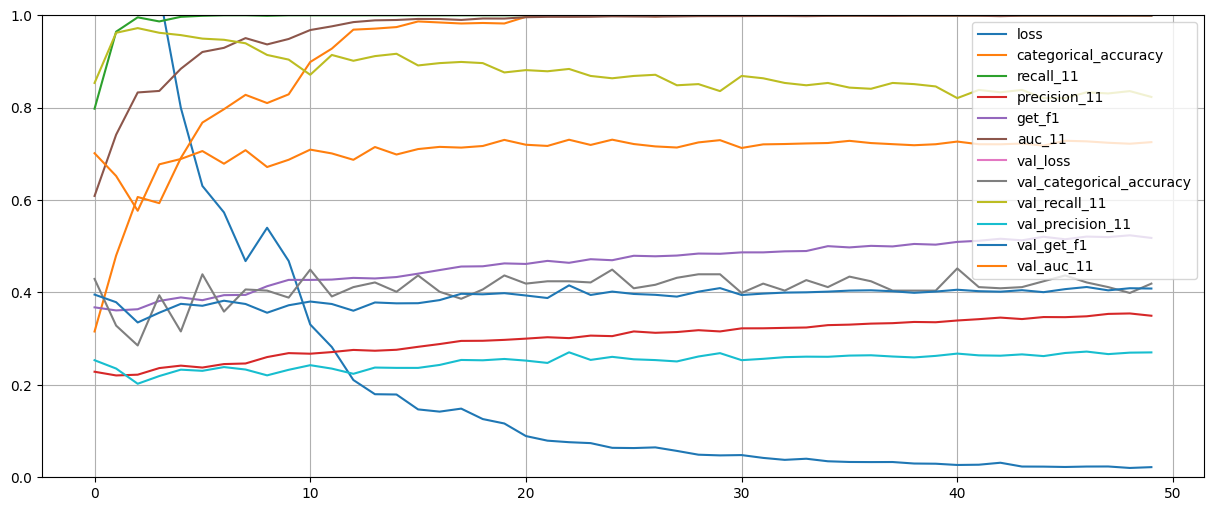

In [74]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_Xception_without_Aug.png")
plt.show()

In [75]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 1s 45ms/step
              precision    recall  f1-score   support

           0       0.42      0.19      0.26        52
           1       0.49      0.71      0.58       170
           2       0.32      0.21      0.26        80
           3       0.20      0.05      0.08        20
           4       0.26      0.24      0.25        74

    accuracy                           0.42       396
   macro avg       0.34      0.28      0.29       396
weighted avg       0.39      0.42      0.39       396



In [76]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_11']))
print(np.std(history.history['val_precision_11']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_11']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_11']))
print(np.mean(history.history['val_precision_11']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_11']))

0.03125854646374619
0.0415383965503147
0.015767918358206384
0.016506922421567097
0.025347642225081252
0.40994949758052823
0.8761111104488373
0.25133281826972964
0.3914484065771103
0.7103544211387635


## Resnet152

In [77]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.resnet.ResNet152(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

234698864/234698864 [==============================] - 8s 0us/step


Epoch 1/50
29/29 [==============================] - 16s 231ms/step - loss: 1.5389 - categorical_accuracy: 0.4144 - recall_12: 0.5544 - precision_12: 0.3166 - get_f1: 0.4188 - auc_12: 0.6836 - val_loss: 1.4522 - val_categorical_accuracy: 0.4394 - val_recall_12: 0.4798 - val_precision_12: 0.3506 - val_get_f1: 0.4078 - val_auc_12: 0.6855
Epoch 2/50
29/29 [==============================] - 4s 131ms/step - loss: 1.4497 - categorical_accuracy: 0.4589 - recall_12: 0.5767 - precision_12: 0.3589 - get_f1: 0.4410 - auc_12: 0.7081 - val_loss: 1.4381 - val_categorical_accuracy: 0.4369 - val_recall_12: 0.6263 - val_precision_12: 0.3163 - val_get_f1: 0.4216 - val_auc_12: 0.7089
Epoch 3/50
29/29 [==============================] - 3s 121ms/step - loss: 1.3816 - categorical_accuracy: 0.4711 - recall_12: 0.5111 - precision_12: 0.4295 - get_f1: 0.4536 - auc_12: 0.7310 - val_loss: 1.4275 - val_categorical_accuracy: 0.4192 - val_recall_12: 0.5253 - val_precision_12: 0.3741 - val_get_f1: 0.4391 - val_auc_12

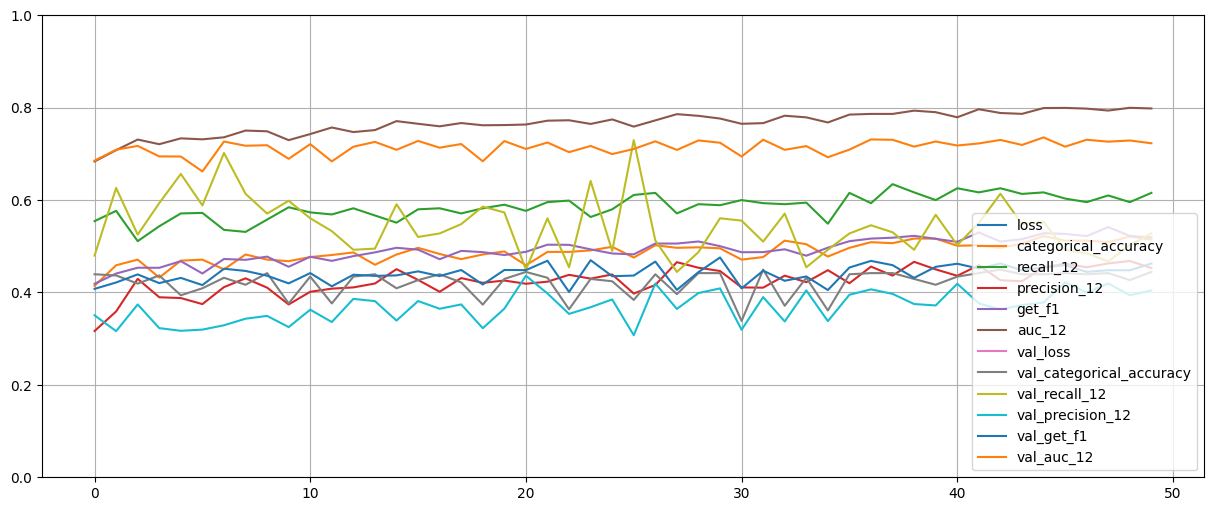

In [78]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_Resnet152_without_Aug.png")
plt.show()

In [79]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 3s 79ms/step
              precision    recall  f1-score   support

           0       0.55      0.12      0.19        52
           1       0.47      0.86      0.61       170
           2       0.34      0.28      0.31        80
           3       0.00      0.00      0.00        20
           4       0.22      0.03      0.05        74

    accuracy                           0.44       396
   macro avg       0.32      0.26      0.23       396
weighted avg       0.38      0.44      0.36       396



In [80]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_12']))
print(np.std(history.history['val_precision_12']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_12']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_12']))
print(np.mean(history.history['val_precision_12']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_12']))

0.026834344925007154
0.06141330924021581
0.032992643862253465
0.01874150523129979
0.015557863098283076
0.4220707046985626
0.5440404093265534
0.3696899914741516
0.4407396984100342
0.7141359317302703
